# Perturbation-Response experiment in Earth-2 MIP

The following notebook demostrates how to use Earth-2 MIP's config schema and builtin inference workflows to perform a deterministic run with a perturbation to the a chosen field `t580` in this case. This is done with FourCastNetv2 small (FCNv2-sm) weather model with an intial state pulled from the Climate Data Store (CDS) and perturbed with random noise. The ensemble output will then be loaded into an Xarray Dataset and some sample data analysis is provided.

In summary this notebook will cover the following topics:

- Configuring and setting up FCNv2 model registry
- An ensemble configuration file
- Running deterministic inference in Earth-2 MIP with localized heating to produce an xarray DataSet
- Post processing results

## Set Up

Starting off with imports, hopefully you have already installed Earth-2 MIP from this repository. There are a few additional packages needed. Lets install these first.

In [1]:
%%capture
!pip install cartopy ecmwflibs h5netcdf

In [2]:
# For running inference we dont need much
import os, json, logging
import xarray

Prior to importing Earth-2 MIP, its critical we set up a few enviroment variables which will help Earth-2 MIP get configured correctly under the hood. There are a number of different global configuration options, the ones will will set here are:

- `WORLD_SIZE`: Tells Earth-2 MIP (which uses Modulus under the hood) the number of GPUs present
- `MODEL_REGISTRY`: This variable tells Earth-2 MIP where look for a model registery

*Key Concept*: A model registry is a folder that Earth-2 MIP will explore to find model checkpoints to load. A folder containing the required fileds is referred to as a "model package". Model packages typically consist of a few files including:
- `weights.tar`: the Pytorch model checkpoint to load
- `metadata.json`: a JSON file that contains meta info regarding various details for using the model
- `config.json`: constains parameters needed to instantiate the model object in python
- `global_means.npy`: A numpy array containing the mean values used for normalization of data in the model
- `global_std.npy`: A numpy array containing the standard deviation values used for normalization of data in the model

In [3]:
# Set number of GPUs to use to 1
os.environ['WORLD_SIZE'] = '1'
# Set model registry as a local folder
model_registry = os.path.join(os.path.dirname(os.path.realpath(os. getcwd())), "models")
os.makedirs(model_registry, exist_ok=True)
os.environ['MODEL_REGISTRY'] = model_registry

# With the enviroment variables set now we import Earth-2 MIP
from earth2mip import inference_ensemble

The cell above created a model registry folder for us, but if this is your first notebook its likely empty. Lets fix that. As previously metioned we will be using the FCNv2-sm weather model with the checkpoint provided on the Nvidia Modulus model registry. The model is shipped via a zip folder containing the required checkpoint files discussed above.

In [4]:
import subprocess
if not os.path.isdir(os.path.join(model_registry, 'fcnv2_sm')):
    subprocess.run(['wget', '-nc', '-P', f'{model_registry}', 'https://api.ngc.nvidia.com/v2/models/nvidia/modulus/modulus_fcnv2_sm/versions/v0.2/files/fcnv2_sm.zip'])
    subprocess.run(['unzip', '-u', f'{model_registry}/fcnv2_sm.zip', '-d', f'{model_registry}'])
    subprocess.run(['rm', f'{model_registry}/fcnv2_sm.zip'])

The final setup step is to set up your CDS API key so we can access ERA5 data to act as an initial state. Earth-2 MIP supports a number of different initial state data sources that are supported including HDF5, CDS, GFS, etc. The CDS initial state provides a convenient way to access a limited amount of historical weather data. Its recommended for accessing an initial state, but larger data requirements should use locally stored weather datasets.

Enter your CDS API uid and key below (found under your profile page). If you don't a CDS API key, find out more here.
- [https://cds.climate.copernicus.eu/cdsapp#!/home](https://cds.climate.copernicus.eu/cdsapp#!/home)
- [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [5]:
# Run this cell and input your credentials in the notebook
uid = input("Enter in CDS UID (e.g. 123456)")
key = input("Enter your CDS API key (e.g. 12345678-1234-1234-1234-123456123456)")

# Write to config file for CDS library
with open(os.path.join(os.path.expanduser("~"), '.cdsapirc'), 'w') as f:
    f.write('url: https://cds.climate.copernicus.eu/api/v2\n')
    f.write(f'key: {uid}:{key}\n')

Enter in CDS UID (e.g. 123456) 211582
Enter your CDS API key (e.g. 12345678-1234-1234-1234-123456123456) 9a810e70-9f48-49b4-9e1b-e7ae17fe15cc


## Running Inference

To run inference we will use the `earth2mip/ensemble_inference.py` part of Earth-2 MIP. When this Python file, we provide either a config JSON file or a JSON serialized string for it to parse. This config contains the information regarding how the model should run inference. The schema of this can be found in `earth2mip/schema/EnsembleRun`.

Since we are working in a notebook, lets create this config Pythonically. There are quite a few parameters that can be used, but lets focus in on a few key ones:

"apply_gaussian_perturbation": True,
    "zonal_location": 0.0,
    "zonal_sigma": 1.0,
    "meridional_location": 0.0,
    "meridional_sigma": 1.0,
    "gaussian_amplitude": 0.005,
    "modified_channel": 't850'
    
- `apply_gaussian_perturbation`: Bool
- `zonal_location`: Zonal location of the gaussian perturbation 
- `zonal_sigma`: Zonal width of the perturbation
- `meridional_location`: Meridional location of the gaussian perturbation 
- `meridional_sigma`: Meridional width of the perturbation
- `gaussian_amplitude`: Amplitude of the gaussian perturbation. For models that run non dimensional make is perecnet of the maximum expected value (here 280)
- `modified_channel`: The selected channel to perturb (for now one at a time)

Note: It is useful to go over `01_ensemble_inference.ipynb`

In [6]:
config =  {
    "ensemble_members": 1,
    "simulation_length": 100,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": "2018-06-01 00:00:00",
            "initial_condition_source": "cds"
        },
        "domains": [
            {
                "name": "global",
                "type": "Window",
                "diagnostics": [
                    {
                        "type": "raw",
                        "channels": [
                            "t2m",
                            "u10m",
                            "v10m",
                            "u850",
                            "v850",
                            "t850",
                            "msl",
                            "z500",
                        ]
                    }
                ]
            }
        ]
    },
    "output_path": "../outputs/03_perturbation-response_notebook",
    "output_frequency": 1,
    "weather_model": "pangu",
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "apply_nudging": True,
    "latitute_location": 0.0,
    "latitute_sigma": 3.0,
    "longitude_location": 0.0,
    "longitude_sigma": 3.0,
    "gaussian_amplitude": 0.5,
    "modified_channels": ["t300", "t400", "t500", "t600", "t700"]
}

Now we run the `main()` function in `earth2mip.inference_ensemble` providing our config object which will run inference with the following steps:

1. Instantiate and load the FCNv2 small weather model onto the device
2. Download the initial state data needed from CDS using your saved API key
3. Perturb the initial state based on the parameters in the config and run a forecast predicton
4. Save output Xarray dataset to NetCDF file located in `../outputs/03_perturbation-response_notebook`

(the process may take a while!)

In [24]:
try:
    os.remove("../outputs/03_perturbation-response_notebook/ensemble_out_0.nc")
except FileNotFoundError:
    print("File not found, skipping.")
config_str = json.dumps(config)
! python3 -m earth2mip.inference_ensemble '{config_str}'

INFO:root:Earth-2 MIP config loaded weather_model='pangu' simulation_length=100 perturbation_strategy=<PerturbationStrategy.correlated: 'correlated'> single_value_perturbation=True noise_reddening=2.0 noise_amplitude=0.05 output_frequency=1 output_grid=None ensemble_members=1 seed=12345 ensemble_batch_size=1 forecast_name=None weather_event=WeatherEvent(properties=WeatherEventProperties(name='Globe', start_time=datetime.datetime(2018, 6, 1, 0, 0), initial_condition_source=<InitialConditionSource.cds: 'cds'>, netcdf='', restart=''), domains=[Window(type='Window', name='global', lat_min=-90, lat_max=90, lon_min=0, lon_max=360, diagnostics=[Diagnostic(type='raw', function='', channels=['t2m', 'u10m', 'v10m', 'u850', 'v850', 't850', 'msl', 'z500'], nbins=10)])]) output_dir=None output_path='../outputs/03_perturbation-response_notebook' restart_frequency=None apply_nudging=True latitute_location=0.0 latitute_sigma=3.0 longitude_location=0.0 longitude_sigma=3.0 gaussian_amplitude=0.5 modifie

In [22]:
def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)

output_path = config["output_path"]
domains = config["weather_event"]["domains"][0]["name"]
ensemble_members = config["ensemble_members"]
ds = open_ensemble(os.path.join(output_path, "ensemble_out_0.nc"), domains)
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, ensemble: 1, time: 1)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2018-06-01
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 ...
    imax     int64 ...
    jmin     int64 ...
    jmax     int64 ...
    t2m      (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u10m     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    v10m     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u850     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    v850     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    t850     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    msl      (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    z500     (ensemble, time, lat, lon) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
Attributes:
    model:          pangu
    config:         {"weather_model": "pangu", "simulation_length": 100, "per...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2018-06-0...
    date_created:   2023-09-27T14:12:27.349531
    history:        /usr/local/lib/python3.10/dist-packages/earth2mip/inferen...
    institution:    NVIDIA
    Conventions:    CF-1.10

## Post Processing

With inference complete, now the fun part: post processing and analysis!
You can manipulate the data to your hearts content now that its in an Xarray Dataset.
Here we will demonstrate some common plotting / analysis workflows one may be interested.
Lets start off with importing all our post processing packages.

In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from io import StringIO
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime, timedelta

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none',
    edgecolor='black'
)

Lets plot the perturbed field at several times. We can read the 

In [11]:
latitute_location = config["latitute_location"]
longitude_location = config["longitude_location"] - 180
modified_channels = config["modified_channels"]

IndexError: Index 1 is out of bounds for axis 1 with size 1

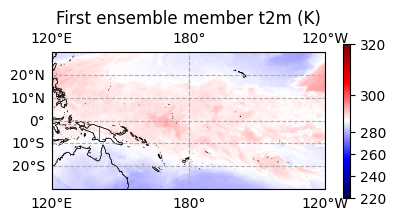

In [12]:
fig = plt.figure(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 100
# proj = ccrs.NearsidePerspective(central_longitude=latitute_location, central_latitude=longitude_location)
proj = ccrs.PlateCarree(central_longitude=180)

data = ds.t850[0,0,:,:]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(131, projection=proj)
ax.set_extent([120,360-120, -30, 30], crs=ccrs.PlateCarree())
ax.set_title('First ensemble member t2m (K)')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=0.5)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.20, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

data = ds.t850[0,1,:,:]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(132, projection=proj)
plt.rcParams['figure.dpi'] = 100
ax.set_title('Last ensemble member t2m (K)')
ax.set_extent([120,360-120, -30, 30], crs=ccrs.PlateCarree())
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=0.5)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.20, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

data = ds.t850[0,2,:,:]
# norm = TwoSlopeNorm(vmin=data.min().values, vcenter=5, vmax=data.max().values)
ax = fig.add_subplot(133, projection=proj)
ax.set_extent([120,360-120, -30, 30], crs=ccrs.PlateCarree())
ax.set_title('ensemble std  t2m (K)')
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic")
ax.coastlines(linewidth=0.5)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.20, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')


plt.show()
IPython.display

We can also see the `z500` behaviour following this perturbation

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 100
proj = ccrs.PlateCarree(central_longitude=180)
levels = np.linspace(240,310,101)
data = ds.z500[0,0,:,:]
u10m = ds.u10m[0,0,:,:]
v10m = ds.v10m[0,0,:,:]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(131, projection=proj)
ax.set_extent([170,360-170, -10, 10], crs=ccrs.PlateCarree())
ax.set_title('First ensemble member t2m (K)')
# img = ax.contour(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), levels = levels)
img = ax.quiver(ds.lon, ds.lat, u10m, v10m)
ax.coastlines(linewidth=0.5)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.20, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

data = ds[modified_channel][0,4,:,:]
u10m = ds.u10m[0,4,:,:]
v10m = ds.v10m[0,4,:,:]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(132, projection=proj)
plt.rcParams['figure.dpi'] = 100
ax.set_title('Last ensemble member t2m (K)')
ax.set_extent([170,360-170, -10, 10], crs=ccrs.PlateCarree())
# img = ax.contour(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), levels = levels)
img = ax.quiver(ds.lon, ds.lat, u10m, v10m)
ax.coastlines(linewidth=0.5)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.20, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')

data = ds[modified_channel][0,8,:,:]
u10m = ds.u10m[0,8,:,:]
v10m = ds.v10m[0,8,:,:]
ax = fig.add_subplot(133, projection=proj)
ax.set_extent([170,360-170, -10, 10], crs=ccrs.PlateCarree())
ax.set_title('ensemble std  t2m (K)')
# img = ax.contour(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), levels = levels)
img = ax.quiver(ds.lon, ds.lat, u10m, v10m)
ax.coastlines(linewidth=0.5)
ax.add_feature(countries, edgecolor='black', linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.20, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle='--')


plt.show()
IPython.display

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors

# Sample ds (DataSet) should be defined above this line.

fig = plt.figure(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 100

# Use PlateCarree for simple rectangular projection
proj = ccrs.PlateCarree()

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')

# First subplot
ax1 = fig.add_subplot(131, projection=proj)
data = ds[modified_channel][0, 0, :, :]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
img1 = ax1.pcolormesh(ds.lon, ds.lat, data, transform=proj, norm=norm, cmap="seismic")
ax1.set_title('First ensemble member t2m (K)')
ax1.coastlines()
ax1.add_feature(countries)
plt.colorbar(img1, ax=ax1, shrink=0.4, norm=mcolors.CenteredNorm(vcenter=0))

# Second subplot
ax2 = fig.add_subplot(132, projection=proj)
data = ds[modified_channel][0, 10, :, :]
img2 = ax2.pcolormesh(ds.lon, ds.lat, data, transform=proj, norm=norm, cmap="seismic")
ax2.set_title('Last ensemble member t2m (K)')
ax2.coastlines()
ax2.add_feature(countries)
plt.colorbar(img2, ax=ax2, shrink=0.4, norm=mcolors.CenteredNorm(vcenter=0))

# Third subplot
ax3 = fig.add_subplot(133, projection=proj)
data = ds[modified_channel][0, 30, :, :]
img3 = ax3.pcolormesh(ds.lon, ds.lat, data, transform=proj, cmap="seismic")
ax3.set_title('Ensemble std t2m (K)')
ax3.coastlines()
ax3.add_feature(countries)
plt.colorbar(img3, ax=ax3, shrink=0.4, norm=mcolors.CenteredNorm(vcenter=0))

plt.show()
